Step 1: Finding the dataset: 

I am using the nfl_data_py module to predict the Win/Loss/Tie record of NFL teams for the 2023 season. The prediction will be based on historical data, player statistics, team performance metrics, and advanced analytics. Selecting the correct datasets ensures that we have comprehensive coverage of variables influencing team outcomes.

We are starting our journey by understanding what there is to offer, ths is done by help(nfl).
This will give us a base understanding of what datasets we have available and short description of said datasets.  
Please note, nfl_data_py is outdated and no longer being updated. We are using an old version of python.

In [21]:
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_ind
from datetime import datetime
from datetime import date
import math 
from sklearn.linear_model import LogisticRegression
import seaborn as sb

In [3]:
help(nfl)


Help on package nfl_data_py:

NAME
    nfl_data_py

DESCRIPTION
    nfl_data_py - a Python package for working with NFL data
    
    **nfl_data_py** is a Python package that streamlines the importing
    of a variety of different American football datasets. It also includes
    tables to assist with the merging of datasets from various sources.
    
    Functions
    ---------
    import_pbp_data() - import play-by-play data
    import_weekly_data() - import weekly player stats
    import_seasonal_data() - import seasonal player stats
    import_snap_counts() - import weekly snap count stats
    import_ngs_data() - import NGS advanced analytics
    import_qbr() - import QBR for NFL or college
    import_seasonal_pfr() - import advanced stats from PFR on a seasonal basis
    import_weekly_pfr() - import advanced stats from PFR on a weekly basis
    import_officials() - import details on game officials
    import_schedules() - import weekly teams schedules
    import_seasonal_rosters() 

Step 2:
Choosing a dataset:

For this project, I have selected the import_pbp_data function from the nfl_data_py library, which provides play-by-play (PBP) data. The dataset is comprehensive, with a shape of (291,093 rows, 391 columns), offering a wealth of information for analysis. The large volume of data ensures that we can explore both granular details and higher-level trends, making it ideal for creating detailed insights.

The pbp dataset includes extensive game-related metrics and team-specific statistics, which makes it highly versatile. It connects directly to the team category while allowing full control over the data. This flexibility empowers us to engineer custom features or aggregated summaries at various levels, such as weekly, seasonal, or multi-seasonal statistics.

By leveraging the pbp dataset, we can analyze individual plays, identify patterns, and build robust models for deriving actionable insights. Its richness and flexibility make it the best choice for detailed exploration and in-depth analysis in the context of football performance and strategy.

In [4]:
#Grab Data
years = range(2018, 2024)
pbp_data = pd.concat([nfl.import_pbp_data(years)])


2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [5]:
pbp_data.head()

,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2018_01_ATL_PHI,2018090600,PHI,ATL,REG,1,None,None,None,...,,,0.0,0.0,NaN,NaN,NaN,None,None,None
1,37.0,2018_01_ATL_PHI,2018090600,PHI,ATL,REG,1,ATL,away,PHI,...,00-0031950;00-0033725;00-0026990;00-0029955;00...,00-0033576;00-0034411;00-0033222;00-0031570;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
2,52.0,2018_01_ATL_PHI,2018090600,PHI,ATL,REG,1,ATL,away,PHI,...,00-0027027;00-0031279;00-0026997;00-0027215;00...,00-0033876;00-0026990;00-0032803;00-0027865;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
3,75.0,2018_01_ATL_PHI,2018090600,PHI,ATL,REG,1,ATL,away,PHI,...,00-0027027;00-0031279;00-0026997;00-0032392;00...,00-0033876;00-0026990;00-0032803;00-0027865;00...,11.0,11.0,8.89,2.502,0.0,HITCH,ZONE_COVERAGE,COVER_3
4,104.0,2018_01_ATL_PHI,2018090600,PHI,ATL,REG,1,ATL,away,PHI,...,00-0027027;00-0031279;00-0026997;00-0027215;00...,00-0033876;00-0026990;00-0032803;00-0027865;00...,11.0,11.0,NaN,NaN,NaN,None,None,None


In [6]:
pbp_data.shape

(291093, 391)

In [7]:
pbp_data.dtypes


play_id                  float32
game_id                   object
old_game_id_x             object
home_team                 object
away_team                 object
                          ...   
time_to_throw            float32
was_pressure             float32
route                     object
defense_man_zone_type     object
defense_coverage_type     object
Length: 391, dtype: object

We are only looking at regular season games and want to bring in month/day/year attributes. 

In [ ]:
pbp =pbp_data[pbp_data['season_type'] == 'REG']
pbp['game_date'] = pd.to_datetime(pbp['game_date']) 
pbp['year'] = pbp['game_date'].dt.year
pbp['month'] = pbp['game_date'].dt.month
pbp['day'] = pbp['game_date'].dt.day



Manually split drive_time_of_poseession to seconds so we can compute later on. We wil convert N/A's/Nulls to 0's.

In [ ]:
pbp['drive_time_of_possession_seconds'] = pbp['drive_time_of_possession'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if pd.notnull(x) else 0
)

In [ ]:

pbp['total_home_epa'] = pbp['total_home_epa'].fillna(0)
pbp['total_away_epa'] = pbp['total_away_epa'].fillna(0)
pbp['home_wp_post'] = pbp['home_wp_post'].fillna(0)
pbp['away_wp_post'] = pbp['away_wp_post'].fillna(0)


In order to get our target column, we need to identify who wins and loses each game. Below we are identifying and creating a new column called 'win' which is derived from away score and home score columns.  

In [ ]:
def calculate_win(row):
    if row['home_score'] > row['away_score']:
        return {'home_team': 1, 'away_team': 0}
    elif row['home_score'] < row['away_score']:
        return {'home_team': 0, 'away_team': 1} 
    else:
        return {'home_team': 0, 'away_team': 0} 

pbp['home_win'] = pbp.apply(lambda row: calculate_win(row)['home_team'], axis=1)
pbp['away_win'] = pbp.apply(lambda row: calculate_win(row)['away_team'], axis=1)


Create a new DataFrame for game-level win aggregation for later usage when implementing target value. 
Along with that, we decided to drop all ties from the pbp dataset. 

In [12]:
game_results = pbp[['game_id', 'home_team', 'away_team', 'home_win', 'away_win','total_home_epa', 'total_away_epa', 'home_wp_post', 'away_wp_post','home_score','away_score']].drop_duplicates()
game_results = game_results[
    ~((game_results['home_win'] == 0) & (game_results['away_win'] == 0))
].reset_index(drop=True)

game_results    

,game_id,home_team,away_team,home_win,away_win,total_home_epa,total_away_epa,home_wp_post,away_wp_post,home_score,away_score
0,2018_01_ATL_PHI,PHI,ATL,1,0,0.000000,0.000000,0.000000,0.000000,18,12
1,2018_01_ATL_PHI,PHI,ATL,1,0,0.000000,0.000000,0.566792,0.433208,18,12
2,2018_01_ATL_PHI,PHI,ATL,1,0,0.773778,-0.773778,0.589110,0.410890,18,12
3,2018_01_ATL_PHI,PHI,ATL,1,0,-0.076340,0.076340,0.579244,0.420756,18,12
4,2018_01_ATL_PHI,PHI,ATL,1,0,-1.082063,1.082063,0.545101,0.454899,18,12
...,...,...,...,...,...,...,...,...,...,...,...
261717,2023_18_TB_CAR,CAR,TB,0,1,-14.731870,14.731870,0.014868,0.985132,0,9
261718,2023_18_TB_CAR,CAR,TB,0,1,-15.546631,15.546631,0.005143,0.994857,0,9
261719,2023_18_TB_CAR,CAR,TB,0,1,-15.049010,15.049010,0.000000,0.000000,0,9
261720,2023_18_TB_CAR,CAR,TB,0,1,-14.296571,14.296571,0.000000,0.000000,0,9


Add in additional columns based on away and home columns (not determined by column: postplay), which will act as features. 


In [13]:
pbp_agg = game_results.groupby(['game_id', 'home_team', 'away_team']).agg({
    'home_score': 'max',
    'away_score': 'max',
    'home_win': 'max',  
    'away_win': 'max',
    'total_home_epa': 'mean',
    'total_away_epa': 'mean',
    'home_wp_post': 'mean',
    'away_wp_post': 'mean'
}).reset_index()

pbp_agg

,game_id,home_team,away_team,home_score,away_score,home_win,away_win,total_home_epa,total_away_epa,home_wp_post,away_wp_post
0,2018_01_ATL_PHI,PHI,ATL,18,12,1,0,-1.246701,1.246701,0.515857,0.433006
1,2018_01_BUF_BAL,BAL,BUF,47,3,1,0,27.952156,-27.952156,0.861436,0.080363
2,2018_01_CHI_GB,GB,CHI,24,23,1,0,-12.640416,12.640416,0.241069,0.681550
3,2018_01_CIN_IND,IND,CIN,23,34,0,1,2.940743,-2.940743,0.608204,0.343892
4,2018_01_DAL_CAR,CAR,DAL,16,8,1,0,8.048952,-8.048952,0.727468,0.182170
...,...,...,...,...,...,...,...,...,...,...,...
1571,2023_18_NYJ_NE,NE,NYJ,3,17,0,1,-6.117496,6.117496,0.339285,0.610082
1572,2023_18_PHI_NYG,NYG,PHI,27,10,1,0,15.400563,-15.400563,0.833097,0.147916
1573,2023_18_PIT_BAL,BAL,PIT,10,17,0,1,-5.538567,5.538567,0.341132,0.581945
1574,2023_18_SEA_ARI,ARI,SEA,20,21,0,1,-1.202948,1.202948,0.485077,0.433162


split home and away results to then concat them into one column for team level stats. 

In [14]:
home_results = pbp_agg[['game_id', 'home_team', 'home_win', 'total_home_epa', 'home_wp_post','home_score']].rename(
    columns={
        'home_team': 'team',
        'home_win': 'win',
        'total_home_epa': 'epa',
        'home_wp_post': 'win_probability',
        'home_score': 'score'
    }
)

away_results = pbp_agg[['game_id', 'away_team', 'away_win', 'total_away_epa', 'away_wp_post','away_score']].rename(
    columns={
        'away_team': 'team',
        'away_win': 'win',
        'total_away_epa': 'epa',
        'away_wp_post': 'win_probability',
        'away_score': 'score'
    }
)

team_results = pd.concat([home_results, away_results])
team_results['game_team_id'] = team_results['game_id'] + "_" + team_results['team']
team_results.reset_index(drop=True, inplace=True)
team_results

,game_id,team,win,epa,win_probability,score,game_team_id
0,2018_01_ATL_PHI,PHI,1,-1.246701,0.515857,18,2018_01_ATL_PHI_PHI
1,2018_01_BUF_BAL,BAL,1,27.952156,0.861436,47,2018_01_BUF_BAL_BAL
2,2018_01_CHI_GB,GB,1,-12.640416,0.241069,24,2018_01_CHI_GB_GB
3,2018_01_CIN_IND,IND,0,2.940743,0.608204,23,2018_01_CIN_IND_IND
4,2018_01_DAL_CAR,CAR,1,8.048952,0.727468,16,2018_01_DAL_CAR_CAR
...,...,...,...,...,...,...,...
3147,2023_18_NYJ_NE,NYJ,1,6.117496,0.610082,17,2023_18_NYJ_NE_NYJ
3148,2023_18_PHI_NYG,PHI,0,-15.400563,0.147916,10,2023_18_PHI_NYG_PHI
3149,2023_18_PIT_BAL,PIT,1,5.538567,0.581945,17,2023_18_PIT_BAL_PIT
3150,2023_18_SEA_ARI,SEA,1,1.202948,0.433162,21,2023_18_SEA_ARI_SEA


Combine datasets by unique ID. sum up by game or get the mean of game to add to our new data set. 

In [15]:
pbp_pr= pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_avg = pbp_pr.groupby(['season','posteam','week','game_id']).agg({
    'passing_yards': 'mean',
    'complete_pass': 'sum',
    'pass': 'sum',
    'rushing_yards': 'mean',
    'rush': 'sum',
    'incomplete_pass' : 'sum',
    'interception':'sum',
    'third_down_converted': 'sum',
    'third_down_failed': 'sum',
    'fourth_down_converted': 'sum',
    'fourth_down_failed': 'sum',
    'first_down_pass': 'sum',
    'first_down_rush': 'sum',
    'fumble': 'sum',
    'drive_time_of_possession_seconds': 'mean',
}).reset_index()

pbp_avg = pbp_avg.rename(columns={
    'pass': 'passing_attempts',
    'rush': 'rushing_attempts',
    'rushing_yards': 'rush_yards_avg',
    'passing_yards': 'passing_yards_avg',
    'posteam':'team',
    'drive_time_of_possession_seconds':'drive_time_of_possession_seconds_avg'
})


pbp_avg['completion_percentage'] = (pbp_avg['complete_pass'] / pbp_avg['passing_attempts']) * 100
pbp_avg['pass_attempt_percentage'] = pbp_avg['passing_attempts'] / (pbp_avg['passing_attempts'] + pbp_avg['rushing_attempts']) * 100
pbp_avg['rush_attempt_percentage'] = pbp_avg['rushing_attempts'] / (pbp_avg['passing_attempts'] + pbp_avg['rushing_attempts']) * 100

pbp_avg['game_team_id'] = pbp_avg['game_id'] + "_" + pbp_avg['team']

pbp_avg = pbp_avg.merge(team_results, on='game_team_id', how='left')

pbp_avg.drop(columns=['game_id_y', 'team_y'], inplace=True)

pbp_avg



,season,team_x,week,game_id_x,passing_yards_avg,complete_pass,passing_attempts,rush_yards_avg,rushing_attempts,incomplete_pass,...,fumble,drive_time_of_possession_seconds_avg,completion_percentage,pass_attempt_percentage,rush_attempt_percentage,game_team_id,win,epa,win_probability,score
0,2018,ARI,1,2018_01_WAS_ARI,7.650000,20.0,39.0,4.928571,13.0,13.0,...,1.0,204.057692,51.282055,75.000000,25.000000,2018_01_WAS_ARI_ARI,0.0,-16.531351,0.161902,6.0
1,2018,ARI,2,2018_02_ARI_LA,5.294117,17.0,30.0,3.600000,15.0,9.0,...,0.0,189.133333,56.666668,66.666672,33.333336,2018_02_ARI_LA_ARI,0.0,-16.935673,0.151407,0.0
2,2018,ARI,3,2018_03_CHI_ARI,11.352942,17.0,33.0,2.944444,17.0,6.0,...,2.0,163.860000,51.515152,66.000000,34.000000,2018_03_CHI_ARI_ARI,0.0,5.040433,0.625104,14.0
3,2018,ARI,4,2018_04_SEA_ARI,12.000000,15.0,33.0,3.285714,27.0,12.0,...,2.0,209.216667,45.454548,55.000000,45.000000,2018_04_SEA_ARI_ARI,0.0,-2.420707,0.436257,17.0
4,2018,ARI,5,2018_05_ARI_SF,17.000000,10.0,27.0,2.950000,20.0,14.0,...,1.0,101.553191,37.037037,57.446808,42.553192,2018_05_ARI_SF_ARI,1.0,8.301068,0.669442,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,2023,WAS,13,2023_13_MIA_WAS,10.583333,12.0,30.0,4.928571,25.0,10.0,...,1.0,209.236364,40.000000,54.545456,45.454548,2023_13_MIA_WAS_WAS,0.0,-23.523245,0.123508,15.0
3162,2023,WAS,15,2023_15_WAS_LA,11.894737,19.0,44.0,3.761905,17.0,16.0,...,1.0,202.442623,43.181820,72.131142,27.868853,2023_15_WAS_LA_WAS,0.0,-12.702415,0.132385,20.0
3163,2023,WAS,16,2023_16_WAS_NYJ,9.750000,16.0,40.0,4.636364,21.0,17.0,...,0.0,135.655738,40.000000,65.573769,34.426231,2023_16_WAS_NYJ_WAS,0.0,-15.116109,0.148232,28.0
3164,2023,WAS,17,2023_17_SF_WAS,9.941176,17.0,32.0,4.428571,14.0,9.0,...,0.0,230.717391,53.125000,69.565216,30.434782,2023_17_SF_WAS_WAS,0.0,-10.510341,0.269640,10.0


In [16]:
pbp_avg.dtypes

season                                    int64
team_x                                   object
week                                      int64
game_id_x                                object
passing_yards_avg                       float32
complete_pass                           float32
passing_attempts                        float32
rush_yards_avg                          float32
rushing_attempts                        float32
incomplete_pass                         float32
interception                            float32
third_down_converted                    float32
third_down_failed                       float32
fourth_down_converted                   float32
fourth_down_failed                      float32
first_down_pass                         float32
first_down_rush                         float32
fumble                                  float32
drive_time_of_possession_seconds_avg    float64
completion_percentage                   float32
pass_attempt_percentage                 

correclation coefficient to see what features impact the target value (wins) the most. 
Here is what we can tell, the mean of win_probability and epa have the greatest correlation to whether a team will win or not. This isn't a complete shock to me as the higher the mean of either one of these values indicates that they are making smarter and better plays throughout the game. 
Score is next on this list, this indicates that if a team scores more, they are more likely to win, also not a suprise. 
The real suprise is rush_attempt_percentage and rushing_attempts, althought not a great correlation, it is worth diving into. I will also say the same for pass_attempt_percentage / passing_attempt.

In [17]:
pbp_num = pbp_avg.select_dtypes(include=['float32', 'int64','float64'])
pbp_num_corr = pbp_num.corr()['win'].drop(['win','week','season'])
pbp_num_corr = pbp_num.corr()['win']
top_features = pbp_num_corr[abs(pbp_num_corr) > .25].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} strongly correlated values with wins:\n{}".format(len(top_features), top_features))


There is 16 strongly correlated values with wins:
win                                     1.000000
win_probability                         0.736867
epa                                     0.672643
score                                   0.556561
rush_attempt_percentage                 0.490172
rushing_attempts                        0.480608
completion_percentage                   0.335115
first_down_rush                         0.326887
drive_time_of_possession_seconds_avg    0.267668
third_down_converted                    0.251436
third_down_failed                      -0.271896
interception                           -0.325289
passing_attempts                       -0.334815
incomplete_pass                        -0.355875
fourth_down_failed                     -0.385446
pass_attempt_percentage                -0.490172
Name: win, dtype: float64


Check for nulls. Ended up finding some Nulls because I only removed ties in one of the datasets so when I merged the data they showed back up. Cleared them and plotted, everything looks good. 

In [18]:

pbp_avg = pbp_avg.dropna(how='any')
Nulls = pbp_avg[pbp_avg['score'].isnull()]
Nulls



,season,team_x,week,game_id_x,passing_yards_avg,complete_pass,passing_attempts,rush_yards_avg,rushing_attempts,incomplete_pass,...,fumble,drive_time_of_possession_seconds_avg,completion_percentage,pass_attempt_percentage,rush_attempt_percentage,game_team_id,win,epa,win_probability,score


Text(0.5, 1.0, 'Total Missing Values')

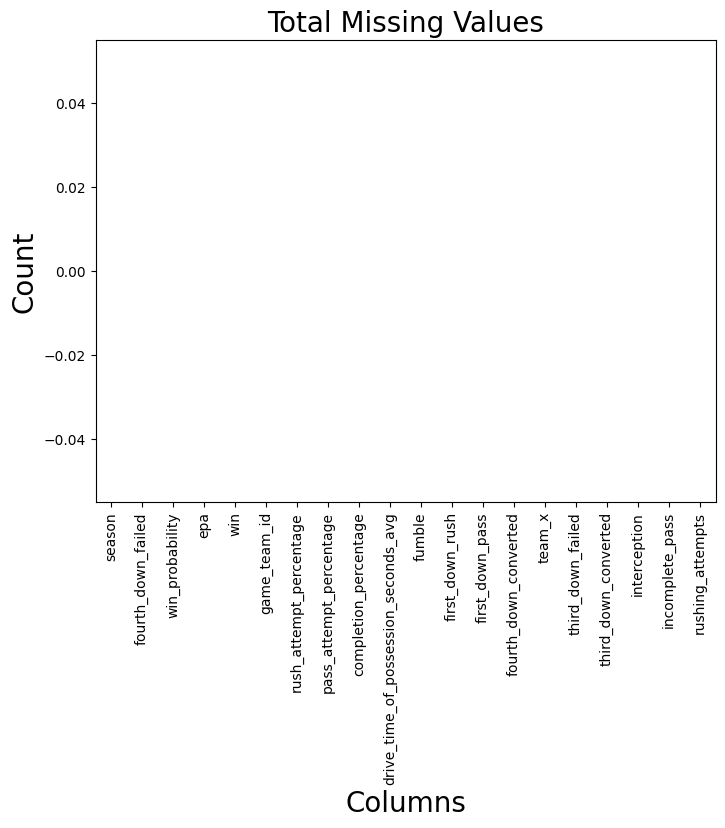

In [22]:
total = pbp_avg.isnull().sum().sort_values(ascending=False)
total_select = total.head(20)
total_select.plot(kind="bar", figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

Visuals below to verify or deny correlcation coefficient we saw earlier. 

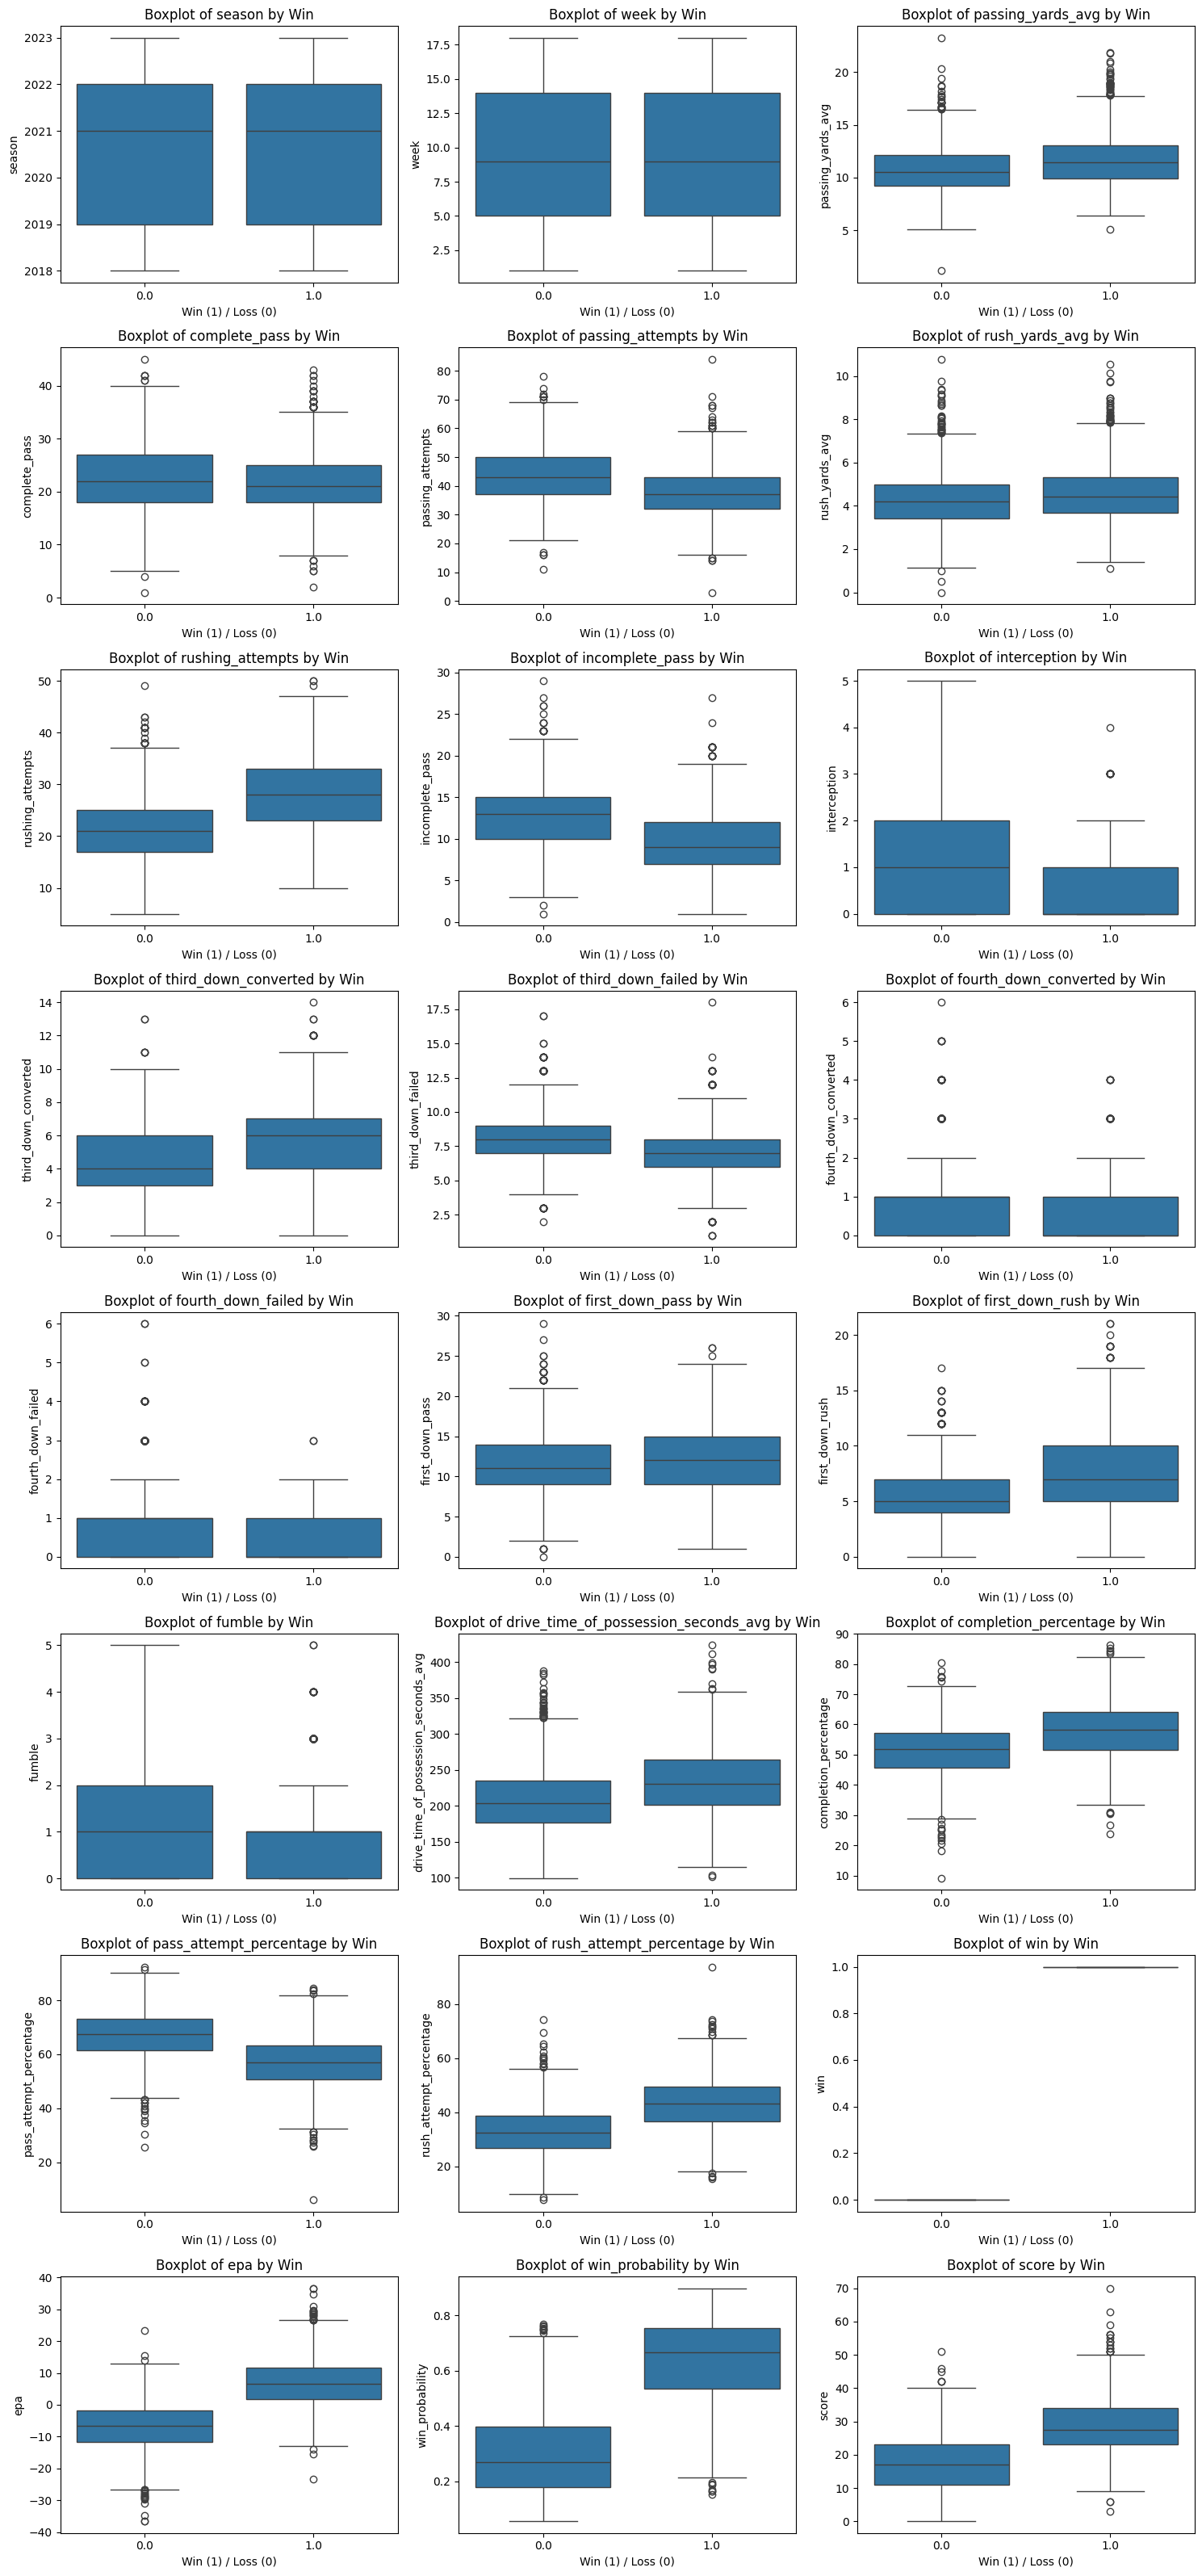

In [ ]:
numeric_cols = [col for col in pbp_avg.columns if pbp_avg[col].dtype in ['float64', 'float32', 'int64']]

n_cols = 3  
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sb.boxplot(x='win', y=col, data=pbp_avg, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Win')
    axes[i].set_xlabel('Win (1) / Loss (0)')
    axes[i].set_ylabel(col)


for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


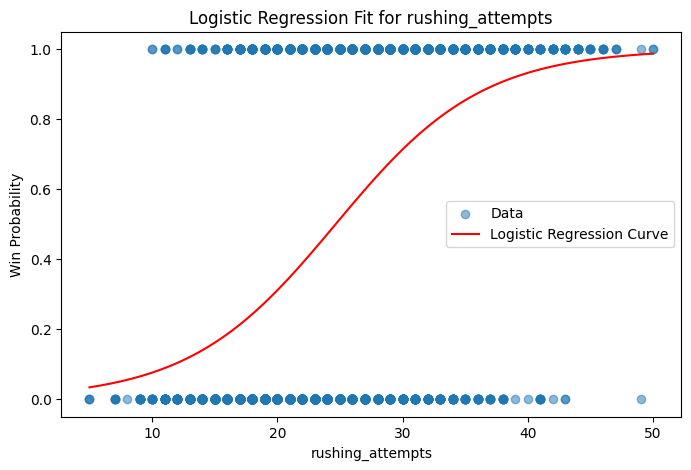

In [24]:


feature = 'rushing_attempts'  
X = pbp_avg[[feature]].values
y = pbp_avg['win'].values

model = LogisticRegression()
model.fit(X, y)


x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_vals = model.predict_proba(x_vals)[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(x_vals, y_vals, color='red', label='Logistic Regression Curve')
plt.title(f'Logistic Regression Fit for {feature}')
plt.xlabel(feature)
plt.ylabel('Win Probability')
plt.legend()
plt.show()


Hypothesis #1:

T-Test
Null Hypothesis: There is no significant difference in rushing attempts between winning and losing games.

Alternative Hypothesis: There is a significant difference in rushing attempts between winning and losing games 

Conclusion:
The p-value is far below 0.05, so we reject the null hypothesis.
Rushing attempts differ significantly between wins and losses. This implies that rushing plays a meaningful role in game outcomes.

In [25]:

add_value = 'rushing_attempts' 
wins = pbp_avg[pbp_avg['win'] == 1][add_value]
losses = pbp_avg[pbp_avg['win'] == 0][add_value]

t_stat, p_value = ttest_ind(wins, losses, equal_var=False)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

if p_value < 0.05:
    print(f"Significant difference: {add_value} impacts game outcomes.")
else:
    print(f"No significant difference: {add_value} does not impact game outcomes.")


T-Statistic: 30.759418442535058, P-Value: 1.1026050980693955e-181
Significant difference: rushing_attempts impacts game outcomes.


T-Test Explanation:
Split target column into wins and losses. 
Identify the amount of rushing attempts between the split dataset and conducts and independent t-test to compare the means of the two groups. 
P-value less than .05 means the feature is significant in determing the target value or rejecting the null hypothesis. (does not mean it is a reason why a team wins (many factors)) 
T-Statistic shows us the how many standard deviations the difference in means is from zero. Large t-stat suggest a strong seperation/difference between groups.


Cohen's d effect size of 1.0958 shows that rushing_attempts has a substantial impact on win values. 

In [29]:
#For my memory: 
# Calculate Cohen's d
mean_wins = wins.mean()
mean_losses = losses.mean()
std_wins = wins.std()
std_losses = losses.std()
n_wins = len(wins)
n_losses = len(losses)

# Pooled standard deviation
pooled_std = np.sqrt(((n_wins - 1) * std_wins**2 + (n_losses - 1) * std_losses**2) / (n_wins + n_losses - 2))

# Cohen's d final product
cohens_d = (mean_wins - mean_losses) / pooled_std
print(f"Cohen's d (effect size): {cohens_d}")

Cohen's d (effect size): 1.095758898469712


Isolating and revisulazing rushing_attempts vs win column by using a boxplot to solidify our answer to reject the null hypthoesis. 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_avg['win'] = pbp_avg['win'].astype(int)

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='win', y=add_value, data=pbp_avg, palette={'0': 'green', '1': 'red'})


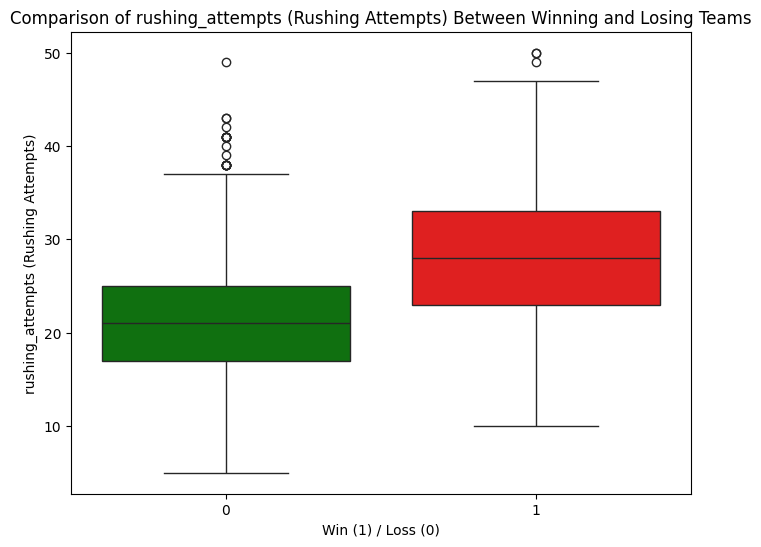

In [28]:

pbp_avg['win'] = pbp_avg['win'].astype(int)

plt.figure(figsize=(8, 6))
sb.boxplot(x='win', y=add_value, data=pbp_avg, palette={'0': 'green', '1': 'red'})
plt.title(f'Comparison of {add_value} (Rushing Attempts) Between Winning and Losing Teams')
plt.xlabel('Win (1) / Loss (0)')
plt.ylabel(f'{add_value} (Rushing Attempts)')
plt.show()


Even though the increase in rushing_attempts means a higher chance of winning. This does not indicate that because a team runs the ball more, they are gonig to win. 
We would need to dive deeper to find out why. Is it because a team is close to winning the game and needs to run the clock out by running the ball? Thus making the other team need to throw more and cause this disperity between win/loss vs rushing attmpts.
Or does it indicate a teams ability to control the game and establish the run game (very important in football) early on. 

In [39]:

feature = 'rushing_attempts'
X = pbp_avg[[feature]]  
y = pbp_avg['win']  


model = LogisticRegression()
model.fit(X, y)

rushing_value = 27
predicted_prob = model.predict_proba([[rushing_value]])[:, 1]
print(f"Probability of winning with {rushing_value} rushing attempts: {predicted_prob[0]}")


Probability of winning with 27 rushing attempts: 0.5985468821224981


C:\Users\rudel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Hypothesis 2: Teams that control time of possession are more likely to win.

Rationale: Time of possession can be an important factor in controlling the flow of the game. Teams that have the ball longer can dictate the pace, wear down the opposition, and have more opportunities to score, which may increase their likelihood of winning.

Hypothesis 3: Teams with higher passing attempt percentages are less likely to win.
Rationale: A high passing attempt percentage may indicate a team is playing from behind and needs to rely on the passing game to catch up, which might correlate with losing. Conversely, teams in the lead may lean more on the running game to manage the clock, resulting in fewer passing attempts.

Next Steps:
1: Expand Feature Analysis: Add new features or investigate additional columns that might have strong correlations with game outcomes, such as advanced metrics on offensive or defensive performance.

2:Include Defensive Metrics: Explore defensive statistics like sacks, interceptions, or opponent passing/rushing yards to see how they correlate with wins. This would provide a more balanced perspective on the factors influencing game outcomes.

3:Time-Series Analysis: Look into trends over time, such as how rushing or passing attempts evolve during a game, especially in different game states (e.g., leading or trailing). Could create new datasets to look at this differently, specifically play by play data. 

4.Clustering: Use clustering algorithms to group teams or games based on similar play styles or metrics, which might reveal hidden patterns.
Feature Engineering: Create composite metrics (e.g., turnover margin, yards per play) to capture more nuanced insights.

5:Feature Engineering: Create composite metrics (e.g., turnover margin, yards per play) to capture more nuanced insights.

Thoughts on data:
The dataset was relatively clean and provided the necessary variables for analysis, but it required significant preprocessing to make it usable. This included handling null values, creating new columns for better feature representation, and filtering out irrelevant data. While the data is comprehensive, its size and complexity introduce noise and increase the time needed to explore and interpret patterns. Moreover, the lack of defensive metrics limited the scope of analysis to primarily offensive statistics.

Request for Additional Data: To gain a deeper understanding, defensive metrics (e.g., opponent rushing attempts, turnovers forced) and situational data (e.g., time left in the game, score margin) would be invaluable. Adding these dimensions could help uncover whether certain play styles or game management strategies lead to consistent success.

